In [1]:

library(ibmdbR)
library(dplyr) 

dsn_driver <- "DASHDB" 
dsn_database <- "BLUDB" 
dsn_hostname <- "awh-yp-small03.services.dal.bluemix.net" 
dsn_port <- "50000" 
dsn_protocol <- "TCPIP" 
dsn_uid <- "dash108052" 
dsn_pwd <- "Hb4vIoK6VYLi"

conn_path <- paste(dsn_driver,";DATABASE=",dsn_database, ";HOSTNAME=",dsn_hostname, ";PORT=",dsn_port,";PROTOCOL=",dsn_protocol,";UID=",dsn_uid,";PWD=",dsn_pwd,sep="")

con <- idaConnect(conn_path)
idaInit(con)
idaShowTables()

Loading required package: RODBC
Loading required package: Matrix
Loading required package: arules

Attaching package: ‘arules’

The following objects are masked from ‘package:SparkR’:

    decode, encode, size

The following objects are masked from ‘package:base’:

    abbreviate, write


Attaching package: ‘dplyr’

The following objects are masked from ‘package:arules’:

    intersect, recode, setdiff, setequal, union

The following objects are masked from ‘package:SparkR’:

    arrange, between, coalesce, collect, contains, count, cume_dist,
    dense_rank, desc, distinct, explain, filter, first, group_by,
    intersect, lag, last, lead, mutate, n, n_distinct, ntile,
    percent_rank, rename, row_number, sample_frac, select, sql,
    summarize, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Schema,Name,Owner,Type
DASH108052,AZURE2DASHDB,DASH108052,T
DASH108052,BC_DIM_CORPORATION,DASH108052,T
DASH108052,BC_DIM_LOCATIONS,DASH108052,T
DASH108052,DATA_FRAME_17065,DASH108052,V
DASH108052,DATA_FRAME_50801,DASH108052,V
DASH108052,DATA_FRAME_52660,DASH108052,V
DASH108052,DATA_FRAME_98265,DASH108052,V
DASH108052,DBSENSORTAG_REF_UM,DASH108052,T
DASH108052,DEMO,DASH108052,T
DASH108052,IBM_SEQUENCE_NUMBER,DASH108052,T


In [2]:
# Load the required packages.
library(ggplot2)
library(scales)
library(grid)
library(ibmdbR)




Attaching package: ‘scales’

The following object is masked from ‘package:SparkR’:

    date_format


Attaching package: ‘grid’

The following object is masked from ‘package:SparkR’:

    explode



In [3]:
# If the table for k-means results already exists, delete it.
if(idaExistTable('KMEANS_OUT'))
  idaDeleteTable('KMEANS_OUT')

# Create a data frame that contains only those columns that are needed to generate the model.
idf <- ida.data.frame('SAMPLES.CUSTOMER_CHURN')[,c("ANNUAL_REVENUE_MIL","TOTAL_EMPLOYEES","TOTAL_BUY","TOTAL_BUY_FREQ","CUST_ID")]

# Generate the k-means clustering model.
bkm <- idaKMeans(idf,maxiter=6,id="CUST_ID",outtable="KMEANS_OUT")
bkm

KMeans clustering with 3 clusters of sizes 159, 98, 243

Cluster means:
  CLUSTERID ANNUAL_REVENUE_MIL TOTAL_BUY TOTAL_BUY_FREQ TOTAL_EMPLOYEES
1         1           39.86528  3.333333       11.36478        827.2642
2         2           41.87051  3.418367       11.17347       1420.7347
3         3           38.94144  3.485597       11.25514        261.3333

Within cluster sum of squares by cluster:
[1] 4230723 3895369 4040067

Available components:
[1] "cluster"  "centers"  "withinss" "size"     "distance" "model"   

In [4]:
# The cluster ID is needed to generate the plot diagrams, so it must be added to the original data.
# Create a table that contains only the ID and cluster ID from the output table.
clusterAssignments <- ida.data.frame("KMEANS_OUT")[, c("ID", "CLUSTER_ID")]
# Join this table with the input table on the customer ID. This adds the cluster ID to the original data.
dataWithClusters <- idaMerge(idf,clusterAssignments,by.x='CUST_ID',by.y='ID')

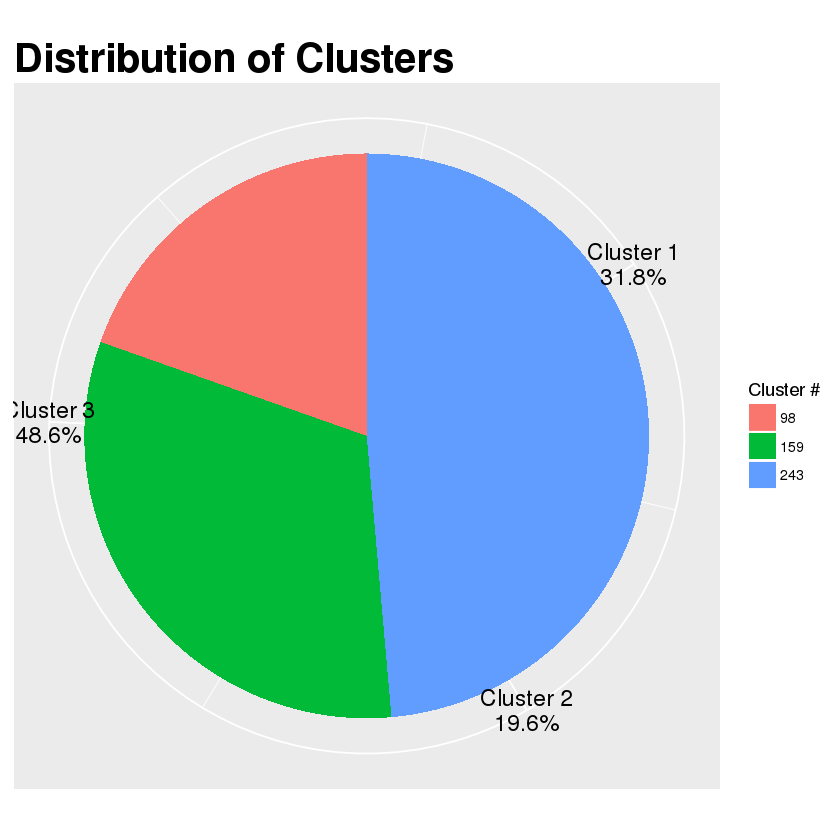

In [7]:
# Plot diagrams can be made only from data that is stored locally, but the contents of the dataWithClusters table are still in the database.
# However, only a subset of the dataWithClusters table is needed to generate the plot diagrams.
# To create this subset, take a stratified sample so that each cluster is represented according to its size.
visSample <- idaSample(dataWithClusters,100,'CLUSTER_ID')
# Convert the character annual revenue amounts from character to numeric data.
visSample$ANNUAL_REVENUE_MIL <- as.numeric(visSample$ANNUAL_REVENUE_MIL)


# Determine sizes and other parameters needed to format the pie chart plot.
sizes <- as.integer(bkm$size)
dfSizes = data.frame(sizes)
percentages = dfSizes$sizes * 100 / sum(dfSizes$sizes)
labelPositions <- cumsum(dfSizes$sizes) - dfSizes$sizes/2
labels = NULL
for (i in 1:dim(dfSizes)[1]) labels[i]=paste("Cluster ", i, "\n", percentages[i], "%", sep=""); 

# Generate the pie chart plot as a JPEG.
jpeg('plot_overview.jpg', width=800, height=800, quality=100)
plotOverview <- ggplot(dfSizes, aes(x=factor(1), y=sizes, fill=factor(sizes))) + 
                geom_bar(width=1, stat="identity") + coord_polar(theta="y") +
                xlab('') + ylab('') + labs(fill='Cluster #') + 
                labs(title="Distribution of Clusters") + 
                scale_y_continuous(breaks=labelPositions, labels=labels) + # labels for slices
                theme(plot.title = element_text(face="bold", color="black", size=24),
                      axis.ticks=element_blank(),  # remove axis ticks
                      axis.title=element_blank(),  # remove axis labels
                      axis.text.y=element_blank(), 
                      axis.text.x=element_text(color='black', size=14)) # label formatting
plotOverview
ignoreReturn <- dev.off()
plotOverview

In [6]:

# Generate the object used to create histogram plots for a single cluster.
plotHistograms <- function(data, model, cluster) {
  
  # create histogram for attribute TOTAL_EMPLOYEES and mark the average of this cluster
  plot_1 <- ggplot(data[data$CLUSTER_ID==cluster, ]) + 
            geom_histogram(aes(x=TOTAL_EMPLOYEES, y=..count../sum(..count..)), binwidth=20, colour="black", fill="white") + 
            scale_y_continuous(labels=percent_format()) + 
            labs(title="Total Employees") + labs(x="Employees",y="Percentage") + 
            geom_vline(aes_string(xintercept=model$centers[cluster, c("TOTAL_EMPLOYEES")]),  color="red", linetype="dashed", size=1)
  # create histogram for attribute ANNUAL_REVENUE_MIL and mark the average of this cluster
  plot_2 <- ggplot(data[data$CLUSTER_ID==cluster, ]) + 
            geom_histogram(aes(x=ANNUAL_REVENUE_MIL, y=..count../sum(..count..)), binwidth=2, colour="black", fill="white") + 
            scale_y_continuous(labels=percent_format()) + 
            labs(title="Annual Revenue") + labs(x="Revenue (in Million $)",y="Percentage") + 
            geom_vline(aes_string(xintercept=model$centers[cluster, c("ANNUAL_REVENUE_MIL")]),  color="red", linetype="dashed", size=1)
  # create histogram for attribute TOTAL_BUY and mark the average of this cluster
  plot_3 <- ggplot(data[data$CLUSTER_ID==cluster, ]) + 
            geom_histogram(aes(x=TOTAL_BUY, y=..count../sum(..count..)), binwidth=1, colour="black", fill="white") + 
            scale_y_continuous(labels=percent_format()) + 
            labs(title="Total Buys") + labs(x="Buys",y="Percentage") + 
            geom_vline(aes_string(xintercept=model$centers[cluster, c("TOTAL_BUY")]),  color="red", linetype="dashed", size=1)
  # create histogram for attribute TOTAL_BUY_FREQ and mark the average of this cluster
  plot_4 <- ggplot(data[data$CLUSTER_ID==cluster, ]) + 
            geom_histogram(aes(x=TOTAL_BUY_FREQ, y=..count../sum(..count..)), binwidth=1, colour="black", fill="white") + 
            scale_y_continuous(labels=percent_format()) + 
            labs(title="Buy Frequency") + labs(x="Buy Frequency",y="Percentage") + 
            geom_vline(aes_string(xintercept=model$centers[cluster, c("TOTAL_BUY_FREQ")]),  color="red", linetype="dashed", size=1)
  
  # Save the histogram plots for a single cluster in a JPEG.
  jpeg(paste('plot', cluster,'.jpg', sep=""), width=800, height=800, quality=100)
  
  # Create a grid to arrange the title and histogram plots
  grid.newpage()
  pushViewport(viewport(layout = grid.layout(3, 2, heights = unit(c(1, 5, 5), "null"))))
  
  grid.text(paste("CLUSTER", cluster), vp = viewport(layout.pos.row = 1, layout.pos.col = 1:2), gp=gpar(fontsize=24, col="black", fontface="bold"))
  
  print(plot_1, vp = viewport(layout.pos.row = 2, layout.pos.col = 1))
  print(plot_2, vp = viewport(layout.pos.row = 2, layout.pos.col = 2))
  print(plot_3, vp = viewport(layout.pos.row = 3, layout.pos.col = 1))
  print(plot_4, vp = viewport(layout.pos.row = 3, layout.pos.col = 2))
  
  # Close the file handle.
  ignoreReturn <- dev.off()
}


# Use the plotHistograms function created previously to plot histograms for each cluster. 
# By comparing the corresponding histograms for the three clusters it becomes evident that the clustering occurred 
# mainly on the TOTAL_EMPLOYEES attribute, which provided the strongest differentiator.
plotHistograms(visSample, bkm, 1)
plotHistograms(visSample, bkm, 2)
plotHistograms(visSample, bkm, 3)

# Clean up temporary tables and close the connection.
idaDeleteTable('KMEANS_OUT')
idaDropView(dataWithClusters@table)
idaClose(con)


ERROR: Error in ggplot(data[data$CLUSTER_ID == cluster, ]): object 'visSample' not found


In [17]:

# Generate the object used to create histogram plots for a single cluster.
plotHistograms <- function(data, model, cluster) {
  
  # create histogram for attribute TOTAL_EMPLOYEES and mark the average of this cluster
  plot_1 <- ggplot(data[data$CLUSTER_ID==cluster, ]) + 
            geom_histogram(aes(x=TOTAL_EMPLOYEES, y=..count../sum(..count..)), binwidth=20, colour="black", fill="white") + 
            scale_y_continuous(labels=percent_format()) + 
            labs(title="Total Employees") + labs(x="Employees",y="Percentage") + 
            geom_vline(aes_string(xintercept=model$centers[cluster, c("TOTAL_EMPLOYEES")]),  color="red", linetype="dashed", size=1)
  # create histogram for attribute ANNUAL_REVENUE_MIL and mark the average of this cluster
  plot_2 <- ggplot(data[data$CLUSTER_ID==cluster, ]) + 
            geom_histogram(aes(x=ANNUAL_REVENUE_MIL, y=..count../sum(..count..)), binwidth=2, colour="black", fill="white") + 
            scale_y_continuous(labels=percent_format()) + 
            labs(title="Annual Revenue") + labs(x="Revenue (in Million $)",y="Percentage") + 
            geom_vline(aes_string(xintercept=model$centers[cluster, c("ANNUAL_REVENUE_MIL")]),  color="red", linetype="dashed", size=1)
  # create histogram for attribute TOTAL_BUY and mark the average of this cluster
  plot_3 <- ggplot(data[data$CLUSTER_ID==cluster, ]) + 
            geom_histogram(aes(x=TOTAL_BUY, y=..count../sum(..count..)), binwidth=1, colour="black", fill="white") + 
            scale_y_continuous(labels=percent_format()) + 
            labs(title="Total Buys") + labs(x="Buys",y="Percentage") + 
            geom_vline(aes_string(xintercept=model$centers[cluster, c("TOTAL_BUY")]),  color="red", linetype="dashed", size=1)
  # create histogram for attribute TOTAL_BUY_FREQ and mark the average of this cluster
  plot_4 <- ggplot(data[data$CLUSTER_ID==cluster, ]) + 
            geom_histogram(aes(x=TOTAL_BUY_FREQ, y=..count../sum(..count..)), binwidth=1, colour="black", fill="white") + 
            scale_y_continuous(labels=percent_format()) + 
            labs(title="Buy Frequency") + labs(x="Buy Frequency",y="Percentage") + 
            geom_vline(aes_string(xintercept=model$centers[cluster, c("TOTAL_BUY_FREQ")]),  color="red", linetype="dashed", size=1)
  
  # Save the histogram plots for a single cluster in a JPEG.
  jpeg(paste('plot', cluster,'.jpg', sep=""), width=800, height=800, quality=100)
  
  # Create a grid to arrange the title and histogram plots
  grid.newpage()
  pushViewport(viewport(layout = grid.layout(3, 2, heights = unit(c(1, 5, 5), "null"))))
  
  grid.text(paste("CLUSTER", cluster), vp = viewport(layout.pos.row = 1, layout.pos.col = 1:2), gp=gpar(fontsize=24, col="black", fontface="bold"))
  
  print(plot_1, vp = viewport(layout.pos.row = 2, layout.pos.col = 1))
  print(plot_2, vp = viewport(layout.pos.row = 2, layout.pos.col = 2))
  print(plot_3, vp = viewport(layout.pos.row = 3, layout.pos.col = 1))
  print(plot_4, vp = viewport(layout.pos.row = 3, layout.pos.col = 2))
  
  # Close the file handle.
  ignoreReturn <- dev.off()
}


# Use the plotHistograms function created previously to plot histograms for each cluster. 
# By comparing the corresponding histograms for the three clusters it becomes evident that the clustering occurred 
# mainly on the TOTAL_EMPLOYEES attribute, which provided the strongest differentiator.
plotHistograms(visSample, bkm, 1)
plotHistograms(visSample, bkm, 2)
plotHistograms(visSample, bkm, 3)

# Clean up temporary tables and close the connection.
idaDeleteTable('KMEANS_OUT')
idaDropView(dataWithClusters@table)
idaClose(con)


ERROR: Error in sqlQuery(get("p_idaConnection", envir = idaRGlobal), query, believeNRows = FALSE, : first argument is not an open RODBC channel


KMeans clustering with 3 clusters of sizes 159, 98, 243

Cluster means:
  CLUSTERID ANNUAL_REVENUE_MIL TOTAL_BUY TOTAL_BUY_FREQ TOTAL_EMPLOYEES
1         1           39.86528  3.333333       11.36478        827.2642
2         2           41.87051  3.418367       11.17347       1420.7347
3         3           38.94144  3.485597       11.25514        261.3333

Within cluster sum of squares by cluster:
[1] 4230723 3895369 4040067

Available components:
[1] "cluster"  "centers"  "withinss" "size"     "distance" "model"   

character(0)

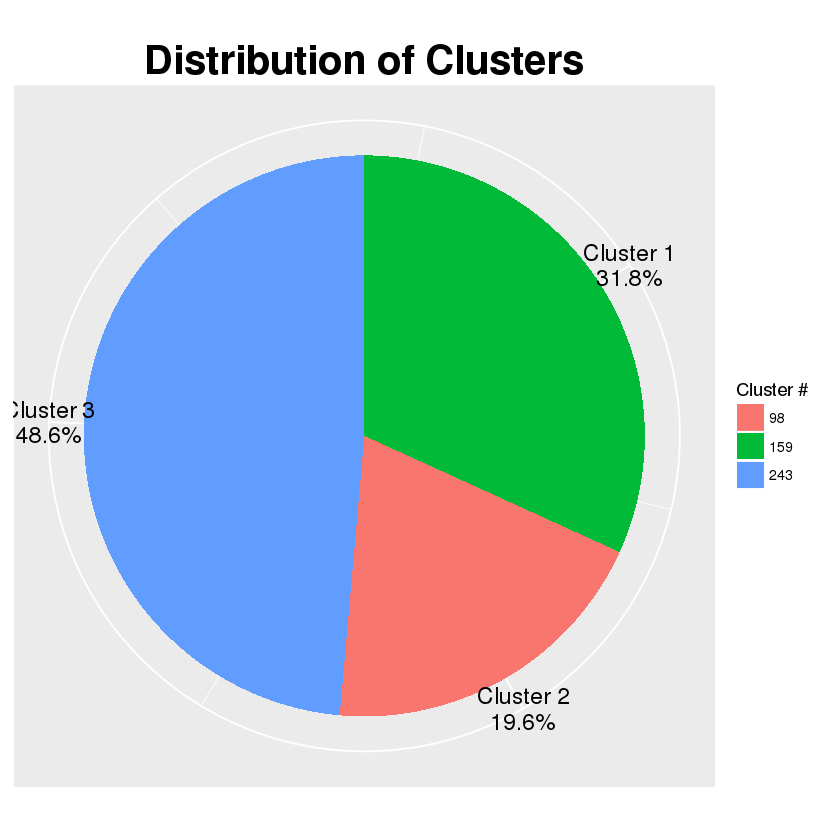

In [7]:
# Load the required packages.
library(ggplot2)
library(scales)
library(grid)
library(ibmdbR)

# Connect to the database that contains the data to be processed.
# con <- idaConnect("BLUDB", "", "")
# idaInit(con)


# If the table for k-means results already exists, delete it.
if(idaExistTable('KMEANS_OUT'))
  idaDeleteTable('KMEANS_OUT')

# Create a data frame that contains only those columns that are needed to generate the model.
idf <- ida.data.frame('SAMPLES.CUSTOMER_CHURN')[,c("ANNUAL_REVENUE_MIL","TOTAL_EMPLOYEES","TOTAL_BUY","TOTAL_BUY_FREQ","CUST_ID")]

# Generate the k-means clustering model.
bkm <- idaKMeans(idf,maxiter=6,id="CUST_ID",outtable="KMEANS_OUT")
bkm

# The cluster ID is needed to generate the plot diagrams, so it must be added to the original data.
# Create a table that contains only the ID and cluster ID from the output table.
clusterAssignments <- ida.data.frame("KMEANS_OUT")[, c("ID", "CLUSTER_ID")]
# Join this table with the input table on the customer ID. This adds the cluster ID to the original data.
dataWithClusters <- idaMerge(idf,clusterAssignments,by.x='CUST_ID',by.y='ID')

# Plot diagrams can be made only from data that is stored locally, but the contents of the dataWithClusters table are still in the database.
# However, only a subset of the dataWithClusters table is needed to generate the plot diagrams.
# To create this subset, take a stratified sample so that each cluster is represented according to its size.
visSample <- idaSample(dataWithClusters,100,'CLUSTER_ID')
# Convert the character annual revenue amounts from character to numeric data.
visSample$ANNUAL_REVENUE_MIL <- as.numeric(visSample$ANNUAL_REVENUE_MIL)


# Determine sizes and other parameters needed to format the pie chart plot.
sizes <- as.integer(bkm$size)
dfSizes = data.frame(sizes)
percentages = dfSizes$sizes * 100 / sum(dfSizes$sizes)
labelPositions <- cumsum(dfSizes$sizes) - dfSizes$sizes/2
labels = NULL
for (i in 1:dim(dfSizes)[1]) labels[i]=paste("Cluster ", i, "\n", percentages[i], "%", sep=""); 

# Generate the pie chart plot as a JPEG.
jpeg('plot_overview.jpg', width=800, height=800, quality=100)
plotOverview <- ggplot(dfSizes, aes(x=factor(1), y=sizes, fill=factor(sizes))) + 
                geom_bar(width=1, stat="identity") + coord_polar(theta="y") +
                xlab('') + ylab('') + labs(fill='Cluster #') + 
                labs(title="Distribution of Clusters") + 
                scale_y_continuous(breaks=labelPositions, labels=labels) + # labels for slices
                theme(plot.title = element_text(face="bold", color="black", size=24),
                      axis.ticks=element_blank(),  # remove axis ticks
                      axis.title=element_blank(),  # remove axis labels
                      axis.text.y=element_blank(), 
                      axis.text.x=element_text(color='black', size=14)) # label formatting
plotOverview
ignoreReturn <- dev.off()
plotOverview


# Generate the object used to create histogram plots for a single cluster.
plotHistograms <- function(data, model, cluster) {
  
  # create histogram for attribute TOTAL_EMPLOYEES and mark the average of this cluster
  plot_1 <- ggplot(data[data$CLUSTER_ID==cluster, ]) + 
            geom_histogram(aes(x=TOTAL_EMPLOYEES, y=..count../sum(..count..)), binwidth=20, colour="black", fill="white") + 
            scale_y_continuous(labels=percent_format()) + 
            labs(title="Total Employees") + labs(x="Employees",y="Percentage") + 
            geom_vline(aes_string(xintercept=model$centers[cluster, c("TOTAL_EMPLOYEES")]),  color="red", linetype="dashed", size=1)
  # create histogram for attribute ANNUAL_REVENUE_MIL and mark the average of this cluster
  plot_2 <- ggplot(data[data$CLUSTER_ID==cluster, ]) + 
            geom_histogram(aes(x=ANNUAL_REVENUE_MIL, y=..count../sum(..count..)), binwidth=2, colour="black", fill="white") + 
            scale_y_continuous(labels=percent_format()) + 
            labs(title="Annual Revenue") + labs(x="Revenue (in Million $)",y="Percentage") + 
            geom_vline(aes_string(xintercept=model$centers[cluster, c("ANNUAL_REVENUE_MIL")]),  color="red", linetype="dashed", size=1)
  # create histogram for attribute TOTAL_BUY and mark the average of this cluster
  plot_3 <- ggplot(data[data$CLUSTER_ID==cluster, ]) + 
            geom_histogram(aes(x=TOTAL_BUY, y=..count../sum(..count..)), binwidth=1, colour="black", fill="white") + 
            scale_y_continuous(labels=percent_format()) + 
            labs(title="Total Buys") + labs(x="Buys",y="Percentage") + 
            geom_vline(aes_string(xintercept=model$centers[cluster, c("TOTAL_BUY")]),  color="red", linetype="dashed", size=1)
  # create histogram for attribute TOTAL_BUY_FREQ and mark the average of this cluster
  plot_4 <- ggplot(data[data$CLUSTER_ID==cluster, ]) + 
            geom_histogram(aes(x=TOTAL_BUY_FREQ, y=..count../sum(..count..)), binwidth=1, colour="black", fill="white") + 
            scale_y_continuous(labels=percent_format()) + 
            labs(title="Buy Frequency") + labs(x="Buy Frequency",y="Percentage") + 
            geom_vline(aes_string(xintercept=model$centers[cluster, c("TOTAL_BUY_FREQ")]),  color="red", linetype="dashed", size=1)
  
  # Save the histogram plots for a single cluster in a JPEG.
  jpeg(paste('plot', cluster,'.jpg', sep=""), width=800, height=800, quality=100)
  
  # Create a grid to arrange the title and histogram plots
  grid.newpage()
  pushViewport(viewport(layout = grid.layout(3, 2, heights = unit(c(1, 5, 5), "null"))))
  
  grid.text(paste("CLUSTER", cluster), vp = viewport(layout.pos.row = 1, layout.pos.col = 1:2), gp=gpar(fontsize=24, col="black", fontface="bold"))
  
  print(plot_1, vp = viewport(layout.pos.row = 2, layout.pos.col = 1))
  print(plot_2, vp = viewport(layout.pos.row = 2, layout.pos.col = 2))
  print(plot_3, vp = viewport(layout.pos.row = 3, layout.pos.col = 1))
  print(plot_4, vp = viewport(layout.pos.row = 3, layout.pos.col = 2))
  
  # Close the file handle.
  ignoreReturn <- dev.off()
}


# Use the plotHistograms function created previously to plot histograms for each cluster. 
# By comparing the corresponding histograms for the three clusters it becomes evident that the clustering occurred 
# mainly on the TOTAL_EMPLOYEES attribute, which provided the strongest differentiator.
plotHistograms(visSample, bkm, 1)
plotHistograms(visSample, bkm, 2)
plotHistograms(visSample, bkm, 3)

# Clean up temporary tables and close the connection.
idaDeleteTable('KMEANS_OUT')
idaDropView(dataWithClusters@table)
idaClose(con)


In [8]:
bkm
print(plot_1, vp = viewport(layout.pos.row = 2, layout.pos.col = 1))

KMeans clustering with 3 clusters of sizes 159, 98, 243

Cluster means:
  CLUSTERID ANNUAL_REVENUE_MIL TOTAL_BUY TOTAL_BUY_FREQ TOTAL_EMPLOYEES
1         1           39.86528  3.333333       11.36478        827.2642
2         2           41.87051  3.418367       11.17347       1420.7347
3         3           38.94144  3.485597       11.25514        261.3333

Within cluster sum of squares by cluster:
[1] 4230723 3895369 4040067

Available components:
[1] "cluster"  "centers"  "withinss" "size"     "distance" "model"   

ERROR: Error in print(plot_1, vp = viewport(layout.pos.row = 2, layout.pos.col = 1)): object 'plot_1' not found
